plot

plot

plot

plot

plot

plot



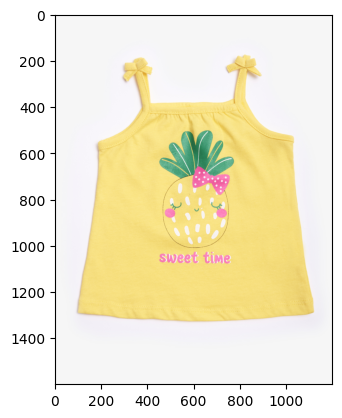

In [11]:
from torchvision.io import read_image
from torch.utils.data import Dataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.io import ImageReadMode
import preproc_tabular
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt


target = [1,2,1,4,2,4,3,5,1,0] #TARGET FAKE
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406) #presi da timm
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)

class CustomDataset(Dataset):
    def __init__(self, references, tabular_data, descriptions, target_file, transform=None, target_transform=None):
        self.img_ref = references 
        self.tabular = tabular_data
        self.descriptions = descriptions
        self.target = target ###
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_ref)
    
    def __getitem__(self, idx):
        image = read_image(self.img_ref[idx], ImageReadMode.RGB)
        image = image.to(torch.float32)
        tabular_row = torch.from_numpy(self.tabular.iloc[idx].values)
        description = self.descriptions[idx]
        #label = self.target.iloc[idx, 1] QUANDO CI SARA IL TARGET
        label = target[idx]
        
        if self.transform: 
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, tabular_row, description, label

def getDataset(references, tabular_data, descriptions, target_file):
    transform_img = transforms.Compose([
        transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
    ])
    
    transform_target = None ######
    
    dataset = CustomDataset(references, tabular_data, descriptions, target_file, transform_img, transform_target)
    
    splitted_dataset = random_split(dataset, [0.6, 0.3, 0.1])
    train_dataloader = DataLoader(splitted_dataset[0], batch_size=1)
    validation_dataloader = DataLoader(splitted_dataset[1], batch_size=1)
    test_dataloader = DataLoader(splitted_dataset[2], batch_size=1)
    return train_dataloader, validation_dataloader, test_dataloader


data, references, descriptions = preproc_tabular.get_tabular('D:\\ORS\\Data\\prova.xlsx')
newdata, newdescription, newreferences = preproc_tabular.duplicate_row('D:\\ORS\\Data\\Images\\', data, descriptions, references)
train, val, test = getDataset(newreferences, newdata, newdescription, "ciao")

for i, d, de, tg in train:
    print("")
